[[7, 7], [8, 6], [9, 6]]
[[7, 7], [8, 6], [9, 5]]
[[7, 7], [7, 6]]


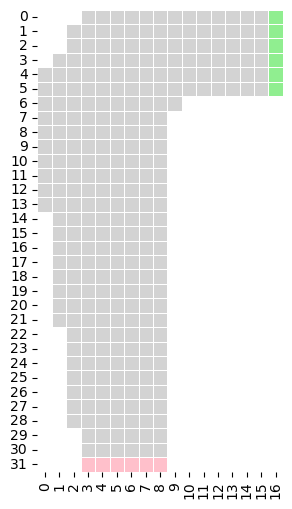

In [1]:
from pathlib import Path
from collections import namedtuple
from typing import Optional
import numpy as np
from numpy import typing as nptype
import matplotlib.pyplot as plt
import seaborn as sns


def generate_discrete_points(
    pos: nptype.NDArray[np.float64], velocity: nptype.NDArray[np.float64]
) -> list[list[int]]:
    if velocity[0] == 0:
        return [[pos[0], pos[1] - step] for step in range(velocity[1] + 1)]

    # The map origin is on top left corner
    norm_velocity = velocity * [1, -1]
    slope = norm_velocity[1] / norm_velocity[0]
    intercept = pos[1] - slope * pos[0]

    start_range = pos[0]
    end_range = pos[0] + norm_velocity[0]
    if start_range > end_range:
        start_range = end_range
        end_range = pos[0]
    return [
        [int(x), int(intercept + slope * x)]
        for x in np.arange(start_range, end_range + 1)
    ]

print(generate_discrete_points(np.array([7, 7]), np.array([2, 1])))
print(generate_discrete_points(np.array([7, 7]), np.array([2, 2])))
print(generate_discrete_points(np.array([7, 7]), np.array([0, 1])))

CarState = namedtuple("CarState", ["pos", "velocity"])


class RaceTrack:
    GRASS = 0
    TRACK = 1
    START = 2
    FINISH = 3
    MAX_VELOCITY = 4

    def __init__(self, file_path: str):
        """
        file_path: can be relative or absolute path to csv file
        """
        self.race_track_map = np.genfromtxt(file_path, delimiter=",")
        self.start_points = np.argwhere(self.race_track_map == RaceTrack.START)
        self.action_space = np.array(
            [[i, j] for i in range(-1, 2) for j in range(-1, 2)]
        )
        self.reset()

    def reset(self):
        rand_idx = np.random.choice(len(self.start_points))
        start_point = self.start_points[rand_idx]
        self.current_state = CarState(
            np.array([start_point[1], start_point[0]]), np.zeros(2, dtype=np.int32)
        )

    def step(self, action: nptype.NDArray[np.int32]):
        next_velocity = np.clip(
            self.current_state.velocity + action, 0, RaceTrack.MAX_VELOCITY
        )
        path = generate_discrete_points(self.current_state.pos, next_velocity)
        valid_points = [
            [x, y]
            for [x, y] in path
            if 0 <= x < self.race_track_map.shape[1]
            and 0 <= y < self.race_track_map.shape[0]
        ]

        out_of_track_points = [
            p
            for p in valid_points[1:]
            if self.race_track_map[p[1], p[0]] == RaceTrack.GRASS
        ]
        if len(out_of_track_points) > 0:
            self.reset()
            return -1, False

        finish_points_on_path = np.array(
            [
                p
                for p in valid_points[1:]
                if self.race_track_map[p[1], p[0]] == RaceTrack.FINISH
            ]
        )
        if len(finish_points_on_path) != 0:
            finish_point = finish_points_on_path[0]
            self.current_state = CarState(
                finish_point, finish_point - self.current_state.pos
            )
            return -1, True
        elif len(path) > len(valid_points):
            self.reset()
            return -1, False
        else:
            self.current_state = CarState(valid_points[-1], next_velocity)
            return -1, False

    def render(self, state_history: Optional[list[CarState]] = None):
        plt.figure(figsize=(12, 6))
        ax = sns.heatmap(
            self.race_track_map,
            cbar=False,
            square=True,
            cmap=["white", "lightgray", "pink", "lightgreen"],
            # xticklabels=False, # type:ignore
            # yticklabels=False, # type:ignore
            linewidths=0.5,  # type:ignore
            linecolor="white",
        )
        state_history = [] if state_history is None else state_history
        xs = [state.pos[0] + 0.5 for state in state_history]
        ys = [state.pos[1] + 0.5 for state in state_history]
        ax.plot(xs, ys, marker="o")


race_track_1 = RaceTrack("./data/figure05-05-left.csv")
race_track_1.render()


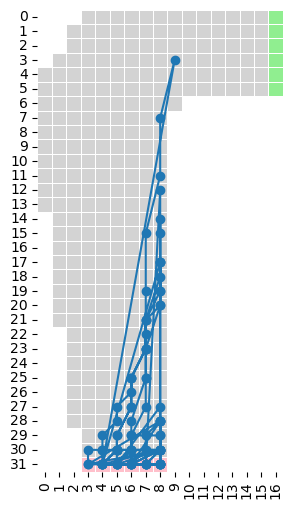

In [2]:
from collections import deque


def sample_random_episode(env: RaceTrack, policy: nptype.NDArray[np.int64], max_time: int, epsilon=0.1):
    env.reset()
    trajectories = deque()
    for t in range(max_time):
        env_current_state = env.current_state
        next_velocities = env.action_space + env.current_state.velocity
        valid_action_idxs = [
            idx
            for idx, next_velocity in enumerate(next_velocities)
            if np.all((next_velocity >= 0) & (next_velocity <= env.MAX_VELOCITY))
            and not np.all(next_velocity == 0)
        ]
        state = (*env_current_state.pos, *env_current_state.velocity)
        action_idx = policy[state]
        is_valid_action = action_idx in valid_action_idxs
        if np.random.random() >= epsilon:
            if is_valid_action:
                action_prob = 1 - epsilon + epsilon / len(valid_action_idxs)
            else:
                action_idx = np.random.choice(valid_action_idxs)
                action_prob = 1 / len(valid_action_idxs)
        else:
            action_idx = np.random.choice(valid_action_idxs)
            action_prob = (epsilon if is_valid_action else 1) / len(valid_action_idxs)

        reward, finished = env.step(env.action_space[action_idx])
        trajectories.appendleft((env_current_state, action_idx, reward, action_prob))
        if finished:
            break
    return trajectories

sample_policy = np.ones((
    *reversed(race_track_1.race_track_map.shape),
    race_track_1.MAX_VELOCITY + 1,
    race_track_1.MAX_VELOCITY + 1,
), dtype=np.int64)
sample_trajectories = sample_random_episode(race_track_1, sample_policy, 100) 
race_track_1.render(
    [race_track_1.current_state]
    + [trajectory[0] for trajectory in list(sample_trajectories)]
)


In [3]:
import logging
import sys

logging.basicConfig(
    format="%(asctime)s %(levelname)s %(name)s %(message)s",
    level=logging.INFO,
    datefmt="%Y-%m-%d %H:%M:%S",
)


def off_policy_mc(env: RaceTrack, discount=1, epsilon=0.1, max_eps=100, max_time=1000):
    logging.info("Start training...")
    # Inititalize
    action_dim = len(env.action_space)
    state_action_dims = (
        *reversed(env.race_track_map.shape),
        env.MAX_VELOCITY + 1,
        env.MAX_VELOCITY + 1,
        action_dim,
    )
    Q = -max_time * np.ones(state_action_dims)
    C = np.zeros(state_action_dims)
    policy = np.argmax(C, axis=-1)

    for ep_num in range(max_eps + 1):
        episode = sample_random_episode(env, policy, max_time)
        G = 0
        W = 1
        for (env_current_state, action, reward, action_prob) in episode:
            state = (*env_current_state.pos, *env_current_state.velocity)
            G = discount * G + reward
            state_action = (*state, action)
            C[state_action] += W
            Q[state_action] += W * (G - Q[state_action]) / C[state_action]
            policy[state] = np.argmax(Q[state])
            if action != policy[state]:
                break
            W /= action_prob
        if ep_num % 1000 == 0:
            logging.info(
                f"Episode {ep_num}/{max_eps}: W={W}, G={G}, {len(episode)}"
            )
    return policy


policy = off_policy_mc(race_track_1, max_eps=20000, max_time=1000)


2023-02-07 13:31:24 INFO root Start training...
2023-02-07 13:31:24 INFO root Episode 0/20000: W=1.2493516635032125e+20, G=-30, 188
2023-02-07 13:31:30 INFO root Episode 1000/20000: W=3.6933502345515166, G=-15, 15
2023-02-07 13:31:34 INFO root Episode 2000/20000: W=4.301261919120555, G=-17, 17
2023-02-07 13:31:38 INFO root Episode 3000/20000: W=9429.42538242531, G=-14, 35
2023-02-07 13:31:41 INFO root Episode 4000/20000: W=2.235461708620049, G=-10, 14
2023-02-07 13:31:45 INFO root Episode 5000/20000: W=4.723651773297871, G=-19, 20
2023-02-07 13:31:48 INFO root Episode 6000/20000: W=200.04045872058444, G=-16, 29
2023-02-07 13:31:51 INFO root Episode 7000/20000: W=1.5927341256425287, G=-6, 13
2023-02-07 13:31:55 INFO root Episode 8000/20000: W=2.6911528088684906, G=-12, 18
2023-02-07 13:31:58 INFO root Episode 9000/20000: W=3.100081281987897, G=-14, 41
2023-02-07 13:32:01 INFO root Episode 10000/20000: W=2.909354387965936, G=-13, 13
2023-02-07 13:32:04 INFO root Episode 11000/20000: W=2.

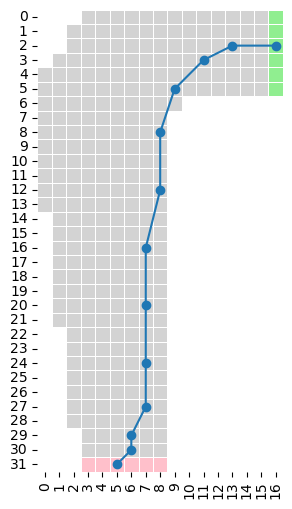

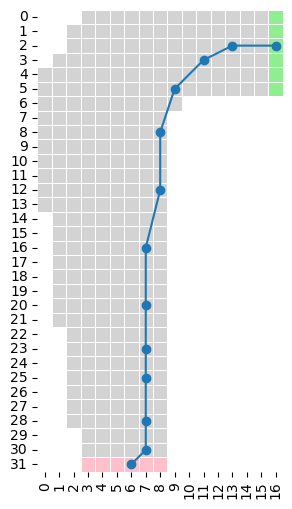

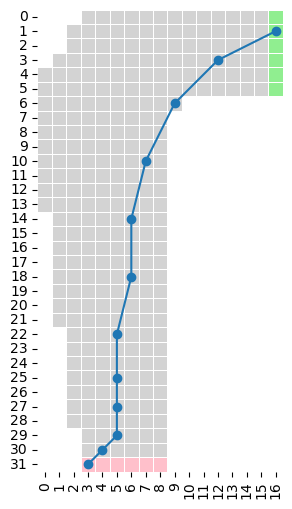

In [4]:
def sample_policy_episode(
    env: RaceTrack, policy: nptype.NDArray[np.int32], max_time: int
):
    env.reset()
    state_history = [env.current_state]
    for iter in range(max_time):
        state = (*env.current_state.pos, *env.current_state.velocity)
        action = policy[state]
        reward, finished = env.step(env.action_space[action])
        state_history.append(env.current_state)
        if finished:
            break
    env.render(state_history)


for _ in range(3):
    sample_policy_episode(race_track_1, policy, 30)
